In [13]:
from dotenv import dotenv_values
from typing import Literal
import json
from math import floor
from rich import print
import matplotlib.pyplot as plt
import requests
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
env = dotenv_values('.env')
env
ANGLE = 0.000_675 # Approx 75m

In [14]:
with open('coords.json', 'r') as file:
    coords = json.load(file)
coord_type = dict[Literal["N", "S", "E", "W"], float]
coords

{'N': 51.2154, 'S': 51.205, 'W': -1.6125, 'E': -1.5865}

In [15]:
resizeResult = tuple[list[float], int, int]

def aspect(lat: float) -> float:
    return 1/np.cos(lat*np.pi/180)

def resize_bbox(coords: coord_type, angle: float) -> resizeResult:
    delta_lat = abs(coords['N'] - coords["S"])
    delta_lon = abs(coords['E'] - coords['W'])
    h_angle = aspect(coords['N'] - delta_lat/2) * angle
    print(h_angle)
    N_lat = floor(delta_lat / angle)
    N_lon = floor(delta_lon / h_angle)

    tl = (
        coords['N'],
        coords['W']
    )
    br = (
        tl[0]-N_lat*angle,
        tl[1]+N_lon*h_angle
    )
    # WSGI84 bounding box
    # south latitude, west longitude, north latitude, east longitude
    bbox = [br[0], tl[1], tl[0], br[1]]
    return bbox, N_lat, N_lon
    
    

def get_elevations(key: str, bbox: list[float], rows: int, cols: int):
    if rows * cols > 1024:
        raise ValueError("Number of points cannot be larger than 1024")
    URL = f"http://dev.virtualearth.net/REST/v1/Elevation/Bounds?bounds={','.join([str(i) for i in bbox])}&rows={rows}&cols={cols}&key={key}"
    
    req = requests.get(URL)
    res = req.json()
    if res['statusCode'] != 200:
        raise Exception(f"error for {URL}     Bad request: {res['statusDescription']}")
    
    return res['resourceSets'][0]['resources'][0]['elevations']
    

In [16]:
resize = resize_bbox(coords=coords, angle=ANGLE)
res = get_elevations(env['BING_KEY'], *resize) # type: ignore


0.0010774742952654368

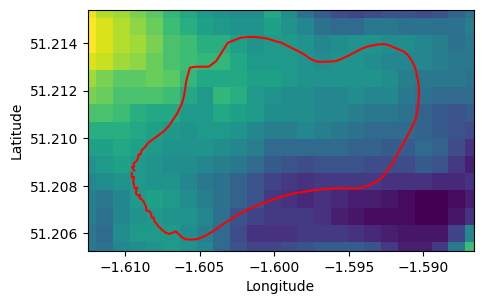

In [18]:
def get_grid(bbox, rows, cols):
    y = np.linspace(bbox[0], bbox[2], rows)
    x = np.linspace(bbox[1], bbox[3], cols)
    return x, y
    
def plot_elevation(ax, bbox, rows, cols, data):

    x, y = get_grid(bbox, rows, cols)

    XX, YY = np.meshgrid(x, y)
    ZZ = np.reshape(data, (rows, cols))


    ax.pcolormesh(XX, YY, ZZ)
    ax.set_aspect(aspect(y[rows//2]))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_xlim((x[0], x[-1]))
    ax.set_ylim(*(y[0], y[-1]))

bbox = resize[0]
aspect_ratio = abs((bbox[2]-bbox[0])/(bbox[3]-bbox[1]))
fig, ax = plt.subplots(1, figsize=(8, 8*aspect_ratio))
plot_elevation(ax, *resize, res)
grid = get_grid(*resize)
path = pd.read_csv("path.csv", index_col=False)
path.lon.to_numpy()

ax.plot(path.lon, path.lat, color='r')
plt.show()


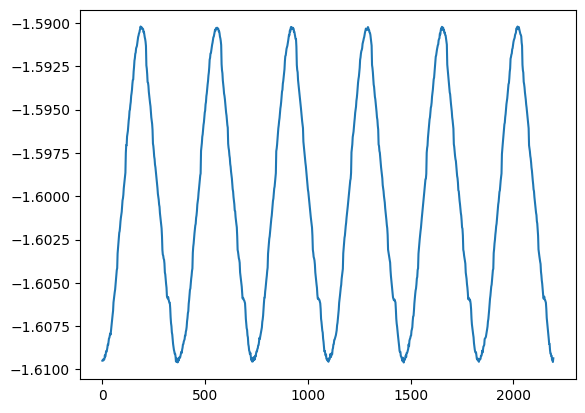

In [34]:
dt = 2 # seconds
path_np = np.stack([path.lon, path.lat], axis=0)

path_np = np.tile(path_np, (1, 6))
jitter = path_np + np.random.normal(0, 0.00005, path_np.shape)
t_jitter = np.arange(jitter.shape[1]) * dt


plt.plot(np.arange(0, jitter.shape[1])*dt, jitter[0])

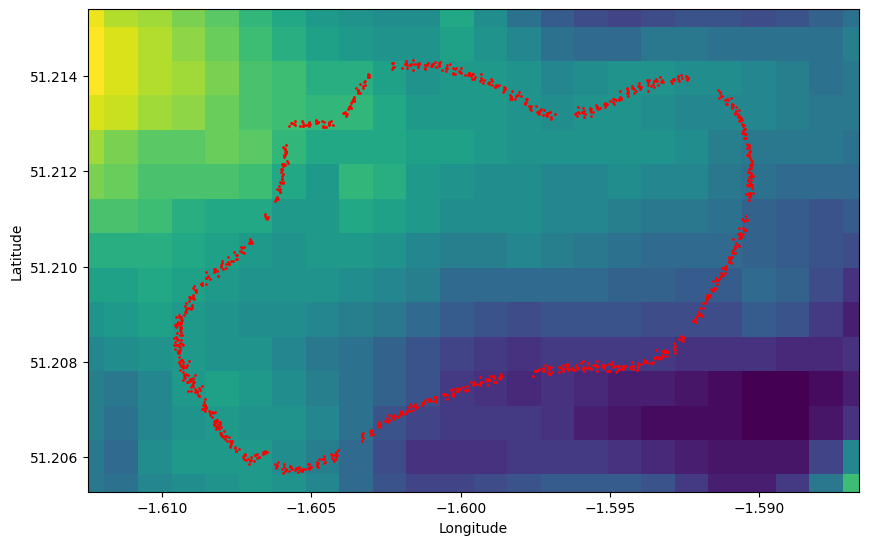

In [36]:
grid

(array([-1.6125    , -1.61137568, -1.61025136, -1.60912704, -1.60800272,
        -1.60687839, -1.60575407, -1.60462975, -1.60350543, -1.60238111,
        -1.60125679, -1.60013247, -1.59900815, -1.59788383, -1.59675951,
        -1.59563518, -1.59451086, -1.59338654, -1.59226222, -1.5911379 ,
        -1.59001358, -1.58888926, -1.58776494, -1.58664062]),
 array([51.205275  , 51.20599821, 51.20672143, 51.20744464, 51.20816786,
        51.20889107, 51.20961429, 51.2103375 , 51.21106071, 51.21178393,
        51.21250714, 51.21323036, 51.21395357, 51.21467679, 51.2154    ]))

grid=((24,),(15,)) resize[1:]=(15, 24)

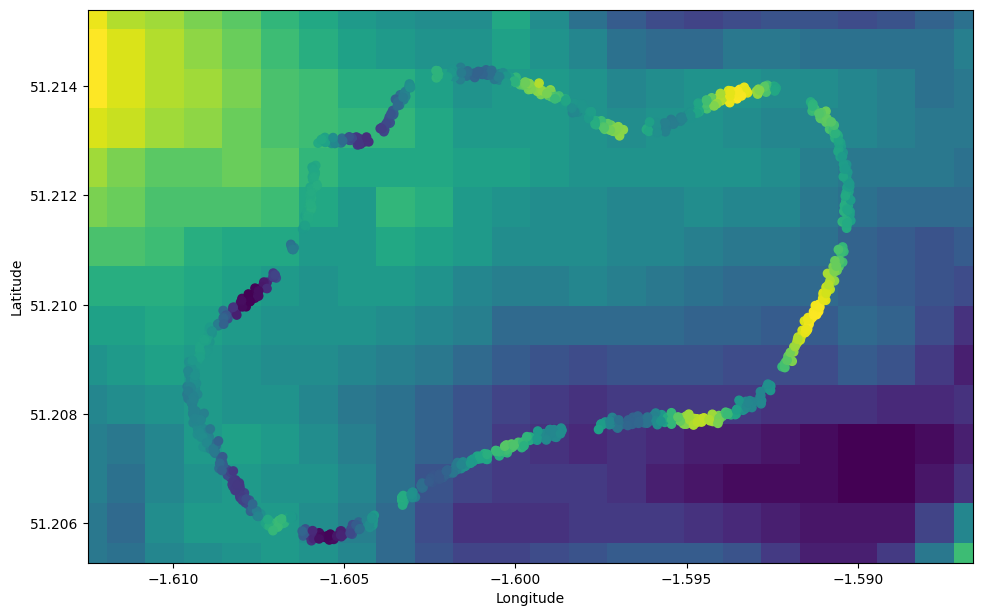

In [39]:
print(f"grid=({','.join([str(i.shape) for i in grid])}) {resize[1:]=}")
interp = RegularGridInterpolator(grid, np.reshape(res, (resize[2], resize[1])), 'cubic')
heights = interp(jitter.T)

fig, ax = plt.subplots(1, figsize=(16, 16*aspect_ratio))
plot_elevation(ax, *resize, res)
ax.scatter(*jitter, c=heights)
plt.tight_layout()
plt.show()
